# Vehicle Detection and Tracking
---

###### The goals / steps of this project are the following:

- Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from scipy.ndimage.measurements import label
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
# from sklearn.cross_validation import train_test_split


### Get Train Images

In [2]:
# Read in cars and notcars
images = glob.glob('images/**/*.png', recursive=True)
cars = []
notcars = []
for image in images:
    if 'non-vehicles' in image:
        notcars.append(image)
    else:
        cars.append(image)
print('number of non car samples: ' + str(len(notcars)))
print('number of car samples: ' + str(len(cars)))

number of non car samples: 8968
number of car samples: 8792


In [3]:
# # Reduce the sample size 
# sample_size = 2000
# cars = cars[0:sample_size]
# notcars = notcars[0:sample_size]

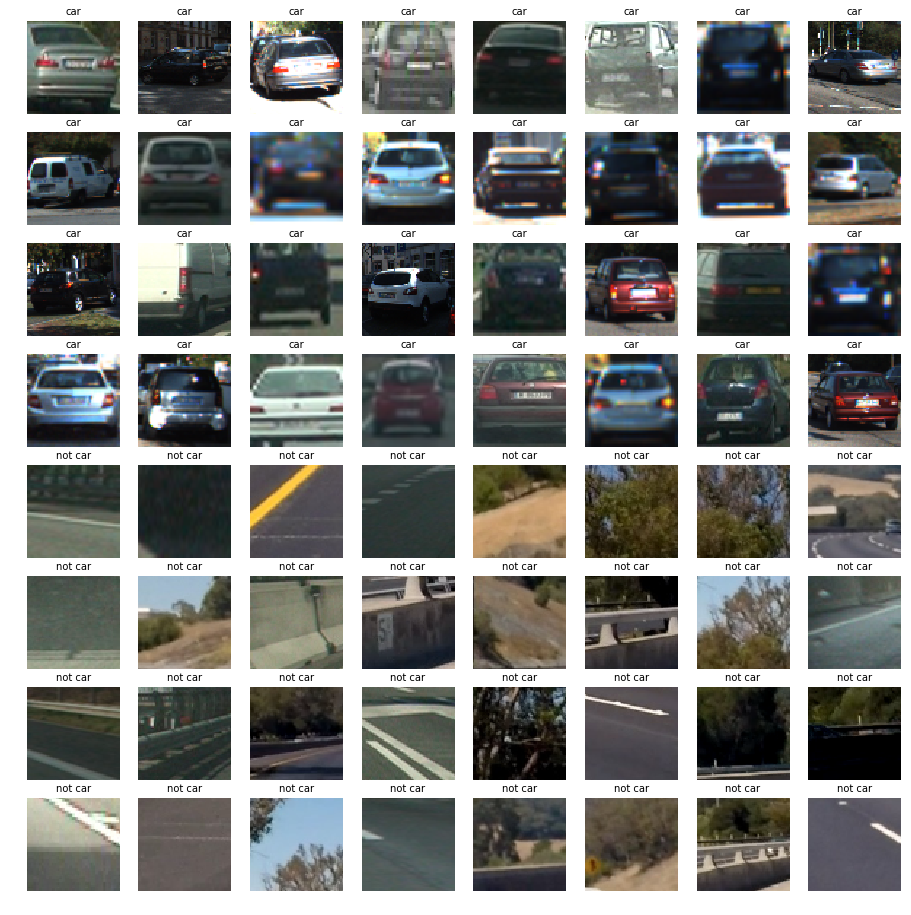

In [4]:
fig, axs = plt.subplots(8,8, figsize=(16, 16))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

# Step through the list and search for chessboard corners
for i in np.arange(32):
    img = cv2.imread(cars[np.random.randint(0,len(cars))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].set_title('car', fontsize=10)
    axs[i].imshow(img)
for i in np.arange(32,64):
    img = cv2.imread(notcars[np.random.randint(0,len(notcars))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].set_title('not car', fontsize=10)
    axs[i].imshow(img)

### Methods

In [5]:
def random_brightness(image):
    proc_img = np.copy(image)
    proc_img = cv2.cvtColor(proc_img, cv2.COLOR_RGB2HSV)
    rate = 0.3 + np.random.uniform()
    proc_img[::2] = proc_img[::2] * rate
    return image, cv2.cvtColor(proc_img, cv2.COLOR_HSV2RGB)

In [6]:
def convert_color(img, cspace='RGB'):
    if cspace != 'RGB':
        if cspace == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
#         ctrans_tosearch = ctrans_tosearch.astype(np.float32) / 255
    else:
        ctrans_tosearch = np.copy(img)
    return ctrans_tosearch

In [7]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block,
                     vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient,
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  block_norm='L2-Hys',
                                  transform_sqrt=False,
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:
        features = hog(img, orientations=orient,
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       block_norm='L2-Hys',
                       transform_sqrt=False,
                       visualise=vis, feature_vector=feature_vec)
        return features

In [8]:
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:, :, 0], size).ravel()
    color2 = cv2.resize(img[:, :, 1], size).ravel()
    color3 = cv2.resize(img[:, :, 2], size).ravel()
    return np.hstack((color1, color2, color3))

In [9]:
def color_hist(img, nbins=32):  # bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:, :, 0], bins=nbins)
    channel2_hist = np.histogram(img[:, :, 1], bins=nbins)
    channel3_hist = np.histogram(img[:, :, 2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


In [10]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                     hist_bins=32, orient=9,
                     pix_per_cell=8, cell_per_block=2, hog_channel=0,
                     spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        # import matplotlib.image as mpimg
        image = mpimg.imread(file)
        feature_image = convert_color(image, color_space)

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
            # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:, :, channel],
                                                         orient, pix_per_cell, cell_per_block,
                                                         vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)
            else:
                hog_features = get_hog_features(feature_image[:, :, hog_channel], orient,
                                                pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

In [146]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,xstart=450):

    rectangles = []
    draw_img = np.copy(img)
    img = img.astype(np.float32) / 255

    img_tosearch = img[ystart:ystop, xstart:, :]
    ctrans_tosearch = convert_color(img_tosearch, cspace='YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1] / scale), np.int(imshape[0] / scale)))

    ch1 = ctrans_tosearch[:, :, 0]
    ch2 = ctrans_tosearch[:, :, 1]
    ch3 = ctrans_tosearch[:, :, 2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1
    nfeat_per_block = orient * cell_per_block ** 2

    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1

    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb * cells_per_step
            xpos = xb * cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            
            xleft = xpos * pix_per_cell
            ytop = ypos * pix_per_cell

            # # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop + window, xleft:xleft + window], (64, 64))

            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))
            # test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))
            test_prediction = svc.predict(test_features)
            # test_prediction = svc.predict(hog_features)

            if test_prediction == 1:
                xbox_left = np.int(xleft * scale)
                ytop_draw = np.int(ytop * scale)
                win_draw = np.int(window * scale)
                rectangles.append(((xbox_left + xstart, ytop_draw + ystart),
                                   (xbox_left + win_draw + xstart, ytop_draw + win_draw + ystart)))

    return rectangles

In [147]:
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

### Set parameters

In [148]:
### TODO: Tweak these parameters and see how the results change.
color_space = 'YCrCb'  # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11  # HOG orientations
pix_per_cell = 14  # HOG pixels per cell
cell_per_block = 2  # HOG cells per block
hog_channel = "ALL"  # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32)  # Spatial binning dimensions
hist_bins = 32  # Number of histogram bins
spatial_feat = True  # Spatial features on or off
hist_feat = True  # Histogram features on or off
hog_feat = True  # HOG features on or off
# y_start_stop = [400, 660]  # Min and max in y to search in slide_window()

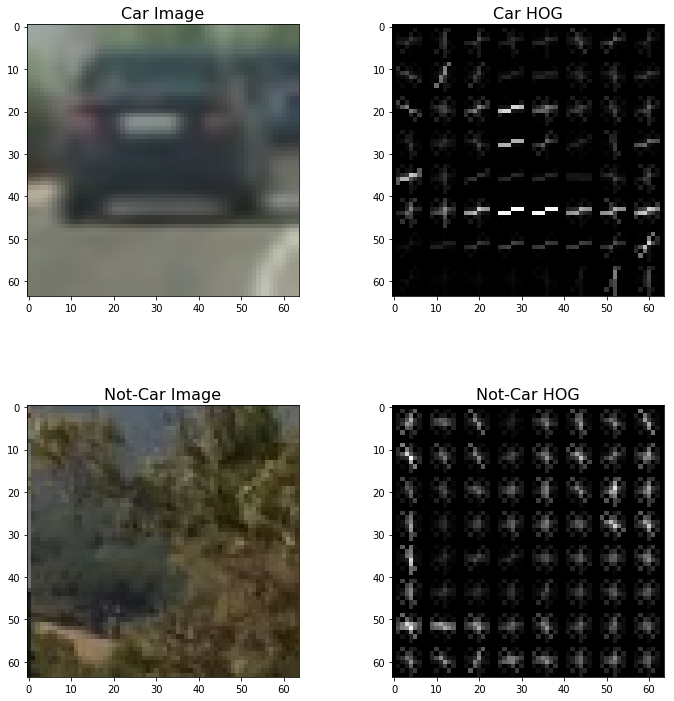

In [149]:
car_img = mpimg.imread(cars[1])
_, car_dst = get_hog_features(car_img[:,:,2], 9, 8, 8, vis=True, feature_vec=True)
notcar_img = mpimg.imread(notcars[1])
_, notcar_dst = get_hog_features(notcar_img[:,:,2], 9, 8, 8, vis=True, feature_vec=True)
# Visualize 
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12,12))
f.subplots_adjust(hspace = .4, wspace=.2)
ax1.imshow(car_img)
ax1.set_title('Car Image', fontsize=16)
ax2.imshow(car_dst, cmap='gray')
ax2.set_title('Car HOG', fontsize=16)
ax3.imshow(notcar_img)
ax3.set_title('Not-Car Image', fontsize=16)
ax4.imshow(notcar_dst, cmap='gray')
ax4.set_title('Not-Car HOG', fontsize=16)
plt.show()

### Train Classifier

In [15]:
t = time.time()
car_features = extract_features(cars, color_space=color_space,
                                spatial_size=spatial_size, hist_bins=hist_bins,
                                orient=orient, pix_per_cell=pix_per_cell,
                                cell_per_block=cell_per_block,
                                hog_channel=hog_channel, spatial_feat=spatial_feat,
                                hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space,
                                   spatial_size=spatial_size, hist_bins=hist_bins,
                                   orient=orient, pix_per_cell=pix_per_cell,
                                   cell_per_block=cell_per_block,
                                   hog_channel=hog_channel, spatial_feat=spatial_feat,
                                   hist_feat=hist_feat, hog_feat=hog_feat)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract features...')

150.4 Seconds to extract features...


In [16]:
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)

### Normalize Data

In [17]:
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

### Train classifier

In [18]:
print('Using:', orient, 'orientations', pix_per_cell,
      'pixels per cell and', cell_per_block, 'cells per block')
print('Feature vector length:', len(X_train[0]))

Using: 11 orientations 14 pixels per cell and 2 cells per block
Feature vector length: 4356


In [19]:
# Use a linear SVC
svc = LinearSVC()
# Check the training time for the SVC
t = time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2 - t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t = time.time()

11.18 Seconds to train SVC...
Test Accuracy of SVC =  0.9862


### Test 'Find_Car' function

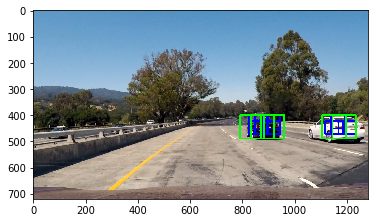

In [136]:
image = mpimg.imread('./test_images/test1.jpg')

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
# image = image.astype(np.float32)/255
draw_image = np.copy(image)
rectangles =[]
rectangles1 = []
rectangles2 = []
rectangles3 = []
rectangles4 = []
rectangles5 = []
draw_image = np.copy(image)

ystart = 400
ystop = 470
scale = 0.8
rectangles1 = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell,
                       cell_per_block, spatial_size, hist_bins)
window_img = draw_boxes(draw_image, rectangles1, color=(0, 0, 255), thick=6)
if not rectangles1 == []:
    rectangles.append(rectangles1)

ystart = 400
ystop = 500
scale = 1.4
rectangles2 = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell,
                       cell_per_block, spatial_size, hist_bins)
window_img = draw_boxes(window_img, rectangles2, color=(0, 255, 0), thick=6)
if not rectangles2 == []:
    rectangles.append(rectangles2)

ystart = 480
ystop = 620
scale = 1.8
rectangles3 = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell,
                       cell_per_block, spatial_size, hist_bins)
window_img = draw_boxes(window_img, rectangles3, color=(0, 0, 255), thick=6)
if not rectangles3 == []:
    rectangles.append(rectangles3)

ystart = 500
ystop = 670
scale = 2.4
rectangles4 = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell,
                       cell_per_block, spatial_size, hist_bins)
window_img = draw_boxes(window_img, rectangles4, color=(0, 255, 0), thick=6)
if not rectangles4 == []:
    rectangles.append(rectangles4)
    
ystart = 500
ystop = 680
scale = 3
rectangles5 = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell,
                       cell_per_block, spatial_size, hist_bins)
window_img = draw_boxes(window_img, rectangles5, color=(255, 0, 0), thick=6)
if not rectangles5 == []:
    rectangles.append(rectangles5)
    
rectangles = [item for sublist in rectangles for item in sublist]  
plt.imshow(window_img)

In [137]:
def get_rectangles(image):
    rectangles =[]
    rectangles1 = []
    rectangles2 = []
    rectangles3 = []
    rectangles4 = []
    rectangles5 = []
    draw_image = np.copy(image)

    ystart = 400
    ystop = 470
    scale = 0.8
    rectangles1 = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell,
                           cell_per_block, spatial_size, hist_bins)
    window_img = draw_boxes(draw_image, rectangles1, color=(0, 0, 255), thick=6)
    if not rectangles1 == []:
        rectangles.append(rectangles1)

    ystart = 400
    ystop = 550
    scale = 1.4
    rectangles2 = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell,
                           cell_per_block, spatial_size, hist_bins)
    window_img = draw_boxes(window_img, rectangles2, color=(0, 255, 0), thick=6)
    if not rectangles2 == []:
        rectangles.append(rectangles2)

    ystart = 480
    ystop = 620
    scale = 1.8
    rectangles3 = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell,
                           cell_per_block, spatial_size, hist_bins)
    window_img = draw_boxes(window_img, rectangles3, color=(0, 0, 255), thick=6)
    if not rectangles3 == []:
        rectangles.append(rectangles3)

    ystart = 500
    ystop = 670
    scale = 2.4
    rectangles4 = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell,
                           cell_per_block, spatial_size, hist_bins)
    window_img = draw_boxes(window_img, rectangles4, color=(0, 255, 0), thick=6)
    if not rectangles4 == []:
        rectangles.append(rectangles4)

    ystart = 500
    ystop = 680
    scale = 3
    rectangles5 = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell,
                           cell_per_block, spatial_size, hist_bins)
    window_img = draw_boxes(window_img, rectangles5, color=(255, 0, 0), thick=6)
    if not rectangles5 == []:
        rectangles.append(rectangles5)

    rectangles = [item for sublist in rectangles for item in sublist]  
    return rectangles, window_img

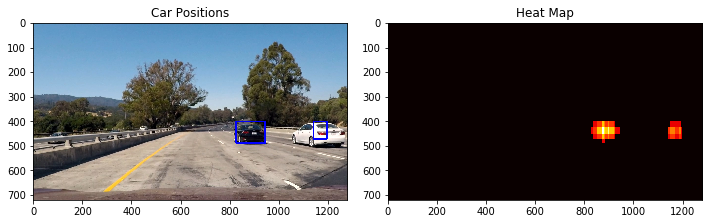

In [138]:
# Read in image similar to one shown above 
heat = np.zeros_like(image[:,:,0]).astype(np.float)

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

# Add heat to each box in box list
heat = add_heat(heat, rectangles)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,2)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

fig = plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()

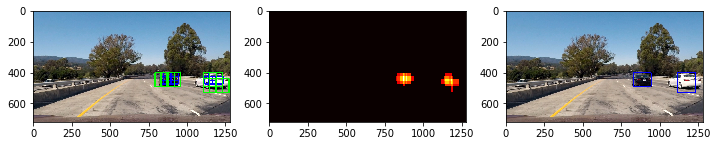

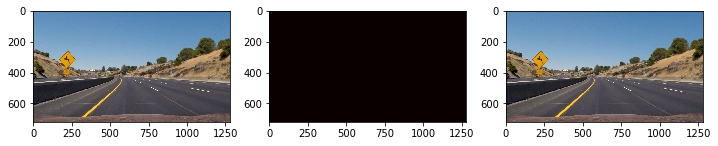

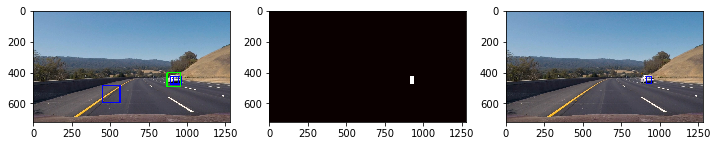

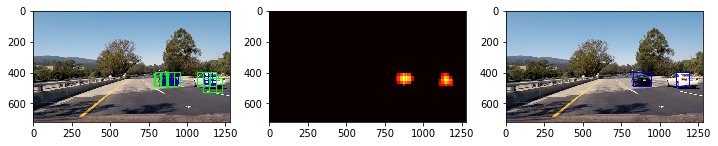

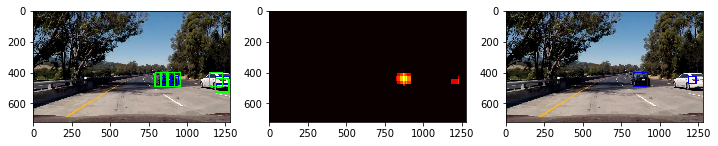

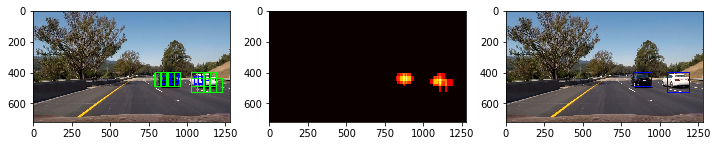

In [139]:
images = glob.glob('./test_images/*.jpg')
for img in images:
    image = mpimg.imread(img)
    rectangles, out_img = get_rectangles(image)
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    heat = add_heat(heat, rectangles)
    threshold =2
    heat = apply_threshold(heat,threshold) 
    heatmap = np.clip(heat, 0, 255)
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)    
    plt.figure(figsize =(12,12))
    plt.subplot(131)
    plt.imshow(out_img)
    plt.subplot(132)
    plt.imshow(heatmap,cmap = "hot")
    plt.subplot(133)
    plt.imshow(draw_img)

## Process image

In [150]:
from collections import deque
history = deque(maxlen = 10)

def process_image(image):
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    rectangles, out_img = get_rectangles(image)
    heat = add_heat(heat, rectangles)
    
    # Apply threshold to help remove false positives
    threshold =1
    heat = apply_threshold(heat,threshold)   
    current_heatmap = np.clip(heat, 0, 255)
    
    history.append(current_heatmap)
    
    #
    heatmap = np.zeros_like(current_heatmap).astype(np.float)
    for heat in history:
        heatmap = heatmap + heat
    
    # averagin the heatmap across the last few frames and reduce false positive
    threshold =10
    heatmap = apply_threshold(heatmap,threshold)   
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)    
    return draw_img

## Create Video

In [152]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

history = deque(maxlen = 20)
output = 'project_video_out.mp4'
clip = VideoFileClip("project_video.mp4")
video_clip = clip.fl_image(process_image)
%time video_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_video_out2_check.mp4
[MoviePy] Writing video project_video_out2_check.mp4


100%|█████████▉| 1260/1261 [06:14<00:00,  3.00it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out2_check.mp4 

CPU times: user 6min, sys: 11.6 s, total: 6min 11s
Wall time: 6min 15s
